In [3]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler

file_path = '/kaggle/input/friends/friends.csv'
df = pd.read_csv(file_path, encoding='utf-8')

df = df[df['character'].isin(['Chandler', 'Rachel'])]
df['dialogue'] = df['dialogue'].fillna('')  
df['dialogue'] = df['dialogue'].astype(str) 

def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'[^\w\s]', '', text)  
    return text

df['dialogue'] = df['dialogue'].apply(preprocess_text)

df_combined = pd.concat([df, df], ignore_index=True)
df_train, df_test = train_test_split(df_combined, test_size=0.2, random_state=42, stratify=df_combined['character'])

label_encoder = LabelEncoder()
df_train['character_encoded'] = label_encoder.fit_transform(df_train['character'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['dialogue'])
sequences_train = tokenizer.texts_to_sequences(df_train['dialogue'])
sequences_test = tokenizer.texts_to_sequences(df_test['dialogue'])
word_index = tokenizer.word_index

max_seq_length = 120
X_train = pad_sequences(sequences_train, maxlen=max_seq_length)
X_test = pad_sequences(sequences_test, maxlen=max_seq_length)
y_train = df_train['character_encoded'].values

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=200, input_length=max_seq_length))
model.add(SpatialDropout1D(0.4)) 
model.add(Bidirectional(LSTM(200, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))) 
model.add(Bidirectional(LSTM(200, dropout=0.4, recurrent_dropout=0.4)))
model.add(Dense(200, activation='relu'))  
model.add(Dropout(0.4)) 
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

optimizer = Adam(learning_rate=0.0003)  
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

model.load_weights('best_model.keras')

df_test['character_encoded'] = label_encoder.transform(df_test['character'])
y_test = df_test['character_encoded'].values

if len(X_test) != len(y_test):
    X_test = X_test[:len(y_test)]

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


333/333 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.5080 - loss: 0.6933 - val_accuracy: 0.6511 - val_loss: 0.6620
Epoch 2/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.6351 - loss: 0.6351 - val_accuracy: 0.6573 - val_loss: 0.6138
Epoch 3/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.7596 - loss: 0.4893 - val_accuracy: 0.7470 - val_loss: 0.4958
Epoch 4/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.8101 - loss: 0.3911 - val_accuracy: 0.7684 - val_loss: 0.4668
Epoch 5/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.8352 - loss: 0.3293 - val_accuracy: 0.7827 - val_loss: 0.4341
Epoch 6/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.8611 - loss: 0.2894 - val_accuracy: 0.7929 - val_loss: 0.4384
Epoch 7/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.8657 - loss: 0.2730 - val_accuracy: 0.7934 - val_loss: 0.4366
Epoch 8/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.8699 - loss: 0.2599 - val_accuracy: 0.800

Chandler'ın En Sık Kullandığı Kelimeler:
bir: 1656
ve: 1067
bu: 1023
tamam: 909
evet: 741
ne: 691
şey: 587
hayır: 507
mi: 504
ben: 481
çok: 469
ah: 443
ama: 443
o: 434
için: 423
mı: 418
hey: 417
değil: 384
musun: 366
bunu: 350

Rachel'ın En Sık Kullandığı Kelimeler:
bir: 1642
bu: 1188
tamam: 1183
ve: 1154
ne: 948
evet: 934
şey: 870
ah: 841
çok: 643
hayır: 631
ama: 611
o: 500
ben: 490
mi: 479
tanrım: 463
için: 441
musun: 433
aman: 429
yani: 425
değil: 418


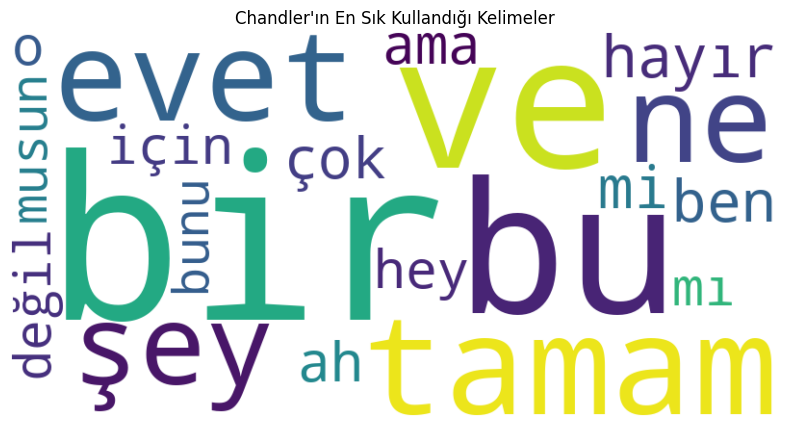

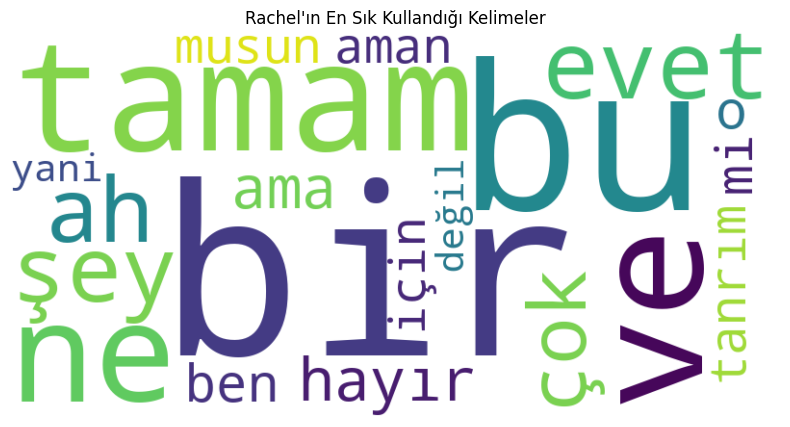

In [5]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

def get_most_common_words(dialogues, num_words=20):
    all_words = ' '.join(dialogues).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(num_words)

# Chandler için en sık kullanılan kelimeler
chandler_dialogues = df[df['character'] == 'Chandler']['dialogue'].tolist()
chandler_common_words = get_most_common_words(chandler_dialogues)
print("Chandler'ın En Sık Kullandığı Kelimeler:")
for word, freq in chandler_common_words:
    print(f"{word}: {freq}")

rachel_dialogues = df[df['character'] == 'Rachel']['dialogue'].tolist()
rachel_common_words = get_most_common_words(rachel_dialogues)
print("\nRachel'ın En Sık Kullandığı Kelimeler:")
for word, freq in rachel_common_words:
    print(f"{word}: {freq}")

def plot_wordcloud(character_name, common_words):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{character_name}\'ın En Sık Kullandığı Kelimeler')
    plt.axis('off')
    plt.show()

plot_wordcloud('Chandler', chandler_common_words)
plot_wordcloud('Rachel', rachel_common_words)


Chandler'ın Ignore Edilen Kelimeler Hariç En Sık Kullandığı Kelimeler:
sadece: 345
var: 322
biliyor: 306
yani: 304
iyi: 289
de: 273
daha: 254
gerçekten: 241
bak: 234
kadar: 227
sen: 223
bana: 214
her: 199
peki: 194
olduğunu: 190
harika: 190
neden: 184
beni: 181
zaman: 179
onu: 177

Rachel'ın Ignore Edilen Kelimeler Hariç En Sık Kullandığı Kelimeler:
bunu: 416
sadece: 415
oh: 406
gerçekten: 386
ross: 386
mı: 379
biliyor: 360
merhaba: 348
var: 345
iyi: 300
bana: 299
hey: 299
sen: 288
joey: 281
de: 266
sana: 245
daha: 238
hadi: 237
kadar: 232
harika: 232


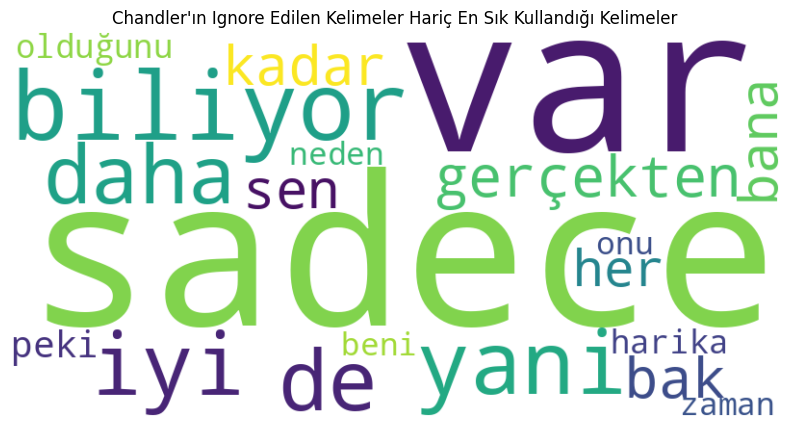

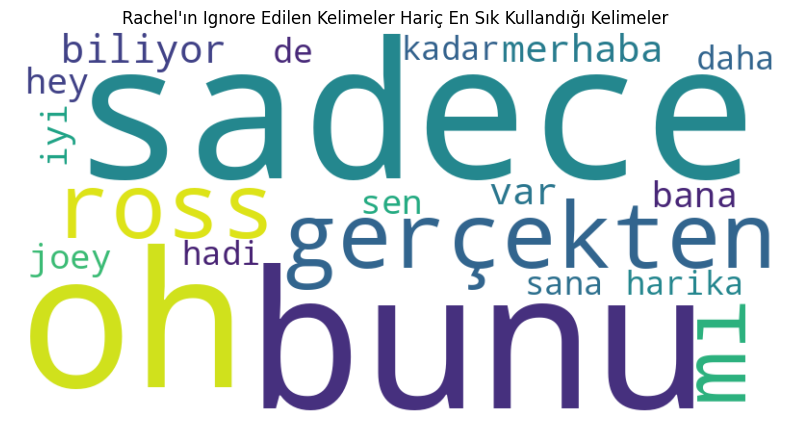

In [6]:
from collections import Counter

ignore_words = {
    'Chandler': {'bir', 've', 'bu', 'tamam', 'evet', 'ne', 'şey', 'hayır', 'mi', 'ben', 'çok', 'ah', 'ama', 'o', 'için', 'mı', 'hey', 'değil', 'musun', 'bunu'},
    'Rachel': {'bir', 'bu', 'tamam', 've', 'ne', 'evet', 'şey', 'ah', 'çok', 'hayır', 'ama', 'o', 'ben', 'mi', 'tanrım', 'için', 'musun', 'aman', 'yani', 'değil'}
}

def filter_words(dialogues, ignore_words):
    all_words = ' '.join(dialogues).split()
    filtered_words = [word for word in all_words if word not in ignore_words]
    return filtered_words

def get_filtered_most_common_words(dialogues, ignore_words, num_words=20):
    filtered_words = filter_words(dialogues, ignore_words)
    word_freq = Counter(filtered_words)
    return word_freq.most_common(num_words)

chandler_filtered_common_words = get_filtered_most_common_words(chandler_dialogues, ignore_words['Chandler'])
print("Chandler'ın Ignore Edilen Kelimeler Hariç En Sık Kullandığı Kelimeler:")
for word, freq in chandler_filtered_common_words:
    print(f"{word}: {freq}")

rachel_filtered_common_words = get_filtered_most_common_words(rachel_dialogues, ignore_words['Rachel'])
print("\nRachel'ın Ignore Edilen Kelimeler Hariç En Sık Kullandığı Kelimeler:")
for word, freq in rachel_filtered_common_words:
    print(f"{word}: {freq}")

def plot_filtered_wordcloud(character_name, common_words):
    """
    Filtrelenmiş kelimeler için kelime bulutu gösterimi.
    :param character_name: Karakter ismi
    :param common_words: Filtrelenmiş kelime frekansları
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{character_name}\'ın Ignore Edilen Kelimeler Hariç En Sık Kullandığı Kelimeler')
    plt.axis('off')
    plt.show()

plot_filtered_wordcloud('Chandler', chandler_filtered_common_words)
plot_filtered_wordcloud('Rachel', rachel_filtered_common_words)


In [7]:
from collections import Counter

ignore_words = {
    'Chandler': {'bir', 've', 'bu', 'tamam', 'evet', 'ne', 'şey', 'hayır', 'mi', 'ben', 'çok', 'ah', 'ama', 'o', 'için', 'mı', 'hey', 'değil', 'musun', 'bunu', 'sadece', 'var', 'biliyor', 'yani', 'iyi', 'de', 'daha', 'gerçekten', 'bak', 'kadar', 'sen', 'bana', 'her', 'peki', 'olduğunu', 'harika', 'neden', 'beni', 'zaman', 'onu'},
    'Rachel': {'bir', 'bu', 'tamam', 've', 'ne', 'evet', 'şey', 'ah', 'çok', 'hayır', 'ama', 'o', 'ben', 'mi', 'tanrım', 'için', 'musun', 'aman', 'yani', 'değil', 'bunu', 'sadece', 'oh', 'gerçekten', 'ross', 'mı', 'biliyor', 'merhaba', 'var', 'iyi', 'bana', 'hey', 'sen', 'joey', 'sana', 'daha', 'hadi', 'kadar', 'harika'}
}

additional_ignore_words = {
    'Chandler': {'sadece', 'var', 'biliyor', 'yani', 'iyi', 'de', 'daha', 'gerçekten', 'bak', 'kadar', 'sen', 'bana', 'her', 'peki', 'olduğunu', 'harika', 'neden', 'beni', 'zaman', 'onu'},
    'Rachel': {'bunu', 'sadece', 'oh', 'gerçekten', 'ross', 'mı', 'biliyor', 'merhaba', 'var', 'iyi', 'bana', 'hey', 'sen', 'joey', 'de', 'sana', 'daha', 'hadi', 'kadar', 'harika'}
}

def filter_words(dialogues, ignore_words):
    all_words = ' '.join(dialogues).split()
    filtered_words = [word for word in all_words if word not in ignore_words]
    return filtered_words

def get_filtered_most_common_words(dialogues, ignore_words, num_words=20):
    filtered_words = filter_words(dialogues, ignore_words)
    word_freq = Counter(filtered_words)
    return word_freq.most_common(num_words)

chandler_ignore_words = ignore_words['Chandler'].union(additional_ignore_words['Chandler'])
rachel_ignore_words = ignore_words['Rachel'].union(additional_ignore_words['Rachel'])

chandler_filtered_common_words = get_filtered_most_common_words(chandler_dialogues, chandler_ignore_words)
print("Chandler'ın Ignore Edilen Kelimeler Hariç En Sık Kullandığı Kelimeler:")
for word, freq in chandler_filtered_common_words:
    print(f"{word}: {freq}")

rachel_filtered_common_words = get_filtered_most_common_words(rachel_dialogues, rachel_ignore_words)
print("\nRachel'ın Ignore Edilen Kelimeler Hariç En Sık Kullandığı Kelimeler:")
for word, freq in rachel_filtered_common_words:
    print(f"{word}: {freq}")


Chandler'ın Ignore Edilen Kelimeler Hariç En Sık Kullandığı Kelimeler:
çünkü: 175
gibi: 171
seni: 169
sana: 167
burada: 163
tanrım: 156
şimdi: 151
hadi: 151
en: 147
sonra: 146
benim: 146
aman: 145
joey: 144
misin: 143
da: 142
biraz: 140
senin: 140
yok: 139
önce: 138
merhaba: 136

Rachel'ın Ignore Edilen Kelimeler Hariç En Sık Kullandığı Kelimeler:
biliyorum: 222
peki: 218
neden: 213
bak: 206
onu: 197
vay: 196
tatlım: 195
olduğunu: 193
her: 191
beni: 191
canına: 191
seni: 178
bilirsin: 177
phoebe: 176
benim: 169
burada: 164
monica: 161
sonra: 160
şimdi: 157
çünkü: 156


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

def build_text_generation_model(vocab_size, seq_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=seq_length))
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def generate_sentence_from_model(model, tokenizer, seed_text, seq_length, num_words):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=seq_length, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted_probs, axis=-1)
        output_word = tokenizer.index_word.get(predicted[0], '')
        seed_text += " " + output_word
    return seed_text

def train_and_generate(character_name):
    character_dialogues = df[df['character'] == character_name]['dialogue'].tolist()
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(character_dialogues)
    total_words = len(text_tokenizer.word_index) + 1

    input_sequences = []
    for line in character_dialogues:
        token_list = text_tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    max_seq_length_text = max([len(x) for x in input_sequences])
    input_sequences = pad_sequences(input_sequences, maxlen=max_seq_length_text, padding='pre')
    X_text, y_text = input_sequences[:,:-1], input_sequences[:,-1]
    y_text = np.eye(total_words)[y_text]

    text_model = build_text_generation_model(total_words, max_seq_length_text-1)
    text_model.fit(X_text, y_text, epochs=20, verbose=1)

    seed_text = "Bu konuda"
    generated_sentence = generate_sentence_from_model(text_model, text_tokenizer, seed_text, max_seq_length_text-1, 10)
    print(f"{character_name} için üretilen cümle: {generated_sentence}")

train_and_generate('Rachel')
train_and_generate('Chandler')


Epoch 1/20
1275/1714 ━━━━━━━━━━━━━━━━━━━━ 3:08 430ms/step - accuracy: 0.0314 - loss: 7.7750